In [1]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from prep_factor import PrepFactor
from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Params
live = True
start = '2005-01-01'
current_date = date.today().strftime('%Y-%m-%d')
window = 60
threshold = 2_000_000_000
stock = read_stock(get_large_dir(live) / 'permno_live.csv')

In [3]:
def month(data):
    data_reset = data.reset_index()
    data_reset = data_reset.set_index('date')
    data_monthly = data_reset.groupby('permno').resample('M').last()
    data_monthly = data_monthly.reset_index(0, drop=True)
    data_monthly = data_monthly.reset_index()
    data_monthly = data_monthly.set_index(['permno', 'date'])
    return data_monthly

In [4]:
# Read in Data
price = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
fund_q = pd.read_parquet(get_parquet_dir(live) / 'data_fund_raw_q.parquet.brotli')
rf = pd.read_parquet(get_parquet_dir(live) / 'data_rf.parquet.brotli')

# Resample to daily
date_index = price.drop(price.columns, axis=1)
fund_q = date_index.merge(fund_q, left_index=True, right_index=True, how='left').groupby('permno').ffill()

# # Resample to month
# price = month(price)
# rf = rf.resample('M').last()

# Value

In [5]:
# Create Book-to-Earnings Ratio
fund_q['btm'] = fund_q['ceqq']/(fund_q['cshoq']*fund_q['prccq'])
btm = fund_q[['btm']]

# Momentum

In [6]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

In [7]:
# Create momentum weights
rf_df = create_multi_index(rf, stock)
mom = price.merge(rf_df, left_index=True, right_index=True, how='left').ffill()
mom = create_return(mom, [1])

In [8]:
def calculate_rolling_momentum(stock_data):
    # Calculate excess return
    stock_data['excess_return'] = stock_data['RET_01'] - stock_data['RF']

    # Calculate the 12-month rolling cumulative excess return, excluding the most recent month
    shifted_excess_return = stock_data['excess_return'].shift(1)
    rolling_momentum = shifted_excess_return.rolling(window=21).sum()

    return rolling_momentum

In [9]:
# Calculate rolling momentum for each stock
mom['mom'] = mom.groupby(level='permno').apply(calculate_rolling_momentum).reset_index(level=0, drop=True)

# Defensive

In [10]:
# Create defensive beta weights
# Read in SPY data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=current_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

# # Resample to monthly
# spy = spy.resample('M').last()

# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
spy_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_spy = spy.columns

# # Resample to monly
# spy_data = month(spy_data)

spy_data = create_return(spy_data, T)
spy_data = spy_data.fillna(0)

# Execute Rolling LR
beta_spy = rolling_ols_parallel(data=spy_data, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.08ticker/s]


In [11]:
defense = beta_spy[[f'SPY_RET_01_spy_01_{window}']]
defense.columns = ['beta']

# Merge

In [12]:
factor = pd.merge(mom, btm, left_index=True, right_index=True, how='left').merge(defense, left_index=True, right_index=True, how='left')

In [13]:
# Add market_cap
market = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])

# # Resample to monthly
# market = month(market)

factor = factor.merge(market, left_index=True, right_index=True, how='left')

In [14]:
df = factor.copy(deep=True)

In [15]:
# Filtering by Market Capitalization
df = df[df['market_cap'] >= threshold]

In [16]:
# Ranking Securities within Each Factor
factors = ['mom', 'btm', 'beta']
for factor_name in factors:
    df[f'{factor_name}_Rank'] = df.groupby('date')[factor_name].rank()

In [17]:
# Calculating Average Rank
df['avg_rank'] = df[[f'{f}_Rank' for f in factors]].mean(axis=1)

In [18]:
# Calculating rank weights
df['rank_weight'] = (1 / len(factors)) * df['avg_rank']

In [19]:
# Calculating inverse volatility (using past 36 months)
df['vol'] = df.groupby('permno')['RET_01'].transform(lambda x: x.rolling(21).std())
df['inv_vol_weight'] = 1 / df['vol']

In [20]:
# Find adjusted weight that accounts for rank and inverse volatility
df['adj_weight'] = df['rank_weight'] * df['inv_vol_weight']

In [21]:
# Function to select top and bottom stocks
def select_top_bottom_stocks(group):
    top_stocks = group.nlargest(25, 'adj_weight')
    bottom_stocks = group.nsmallest(25, 'adj_weight')
    top_stocks['final_weight'] = top_stocks['adj_weight'] * 1
    bottom_stocks['final_weight'] = bottom_stocks['adj_weight'] * -1
    return pd.concat([top_stocks, bottom_stocks])

In [22]:
# Selecting Top and Bottom Stocks
top_bottom_stocks = df.groupby('date').apply(select_top_bottom_stocks).reset_index(level=0, drop=True)

In [23]:
top_bottom_stocks = top_bottom_stocks.loc[~top_bottom_stocks.index.duplicated(keep='first')]

In [24]:
# Normalizing Weights
top_bottom_stocks['final_weight'] /= top_bottom_stocks.groupby('date')['final_weight'].transform(lambda x: x.abs().sum())

# Plot

In [25]:
top_bottom_stocks['total_ret'] = top_bottom_stocks['RET_01'] * top_bottom_stocks['final_weight']

In [26]:
total_ret = top_bottom_stocks.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-03-01   2005-03-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          265.26%      485.23%
CAGR﹪                     4.9%         6.74%

Sharpe                     0.45         1.11
Prob. Sharpe Ratio         97.48%       100.0%
Smart Sharpe               0.44         1.07
Sortino                    0.64         1.55
Smart Sortino              0.61         1.5
Sortino/√2                 0.45         1.1
Smart Sortino/√2           0.43         1.06
Omega                      1.22         1.22

Max Drawdown               -56.47%      -44.89%
Longest DD Days            1982         2146
Volatility (ann.)          19.47%       8.87%
R^2                        0.53         0.53
Information Ratio          0.0          0.0
Calmar                

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-05-22,2009-07-10,2013-04-05,2146,-44.891169,-43.897321
2,2020-02-19,2020-06-26,2021-04-07,414,-16.837359,-16.532281
3,2022-04-22,2022-06-17,2022-10-27,189,-8.650118,-7.754996
4,2018-01-29,2018-03-23,2018-09-05,220,-7.552482,-6.904174
5,2005-08-04,2005-10-13,2005-11-09,98,-5.076351,-4.998855


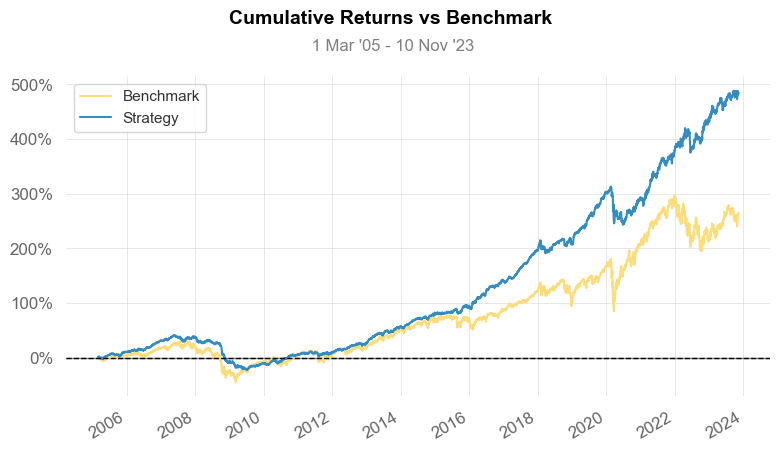

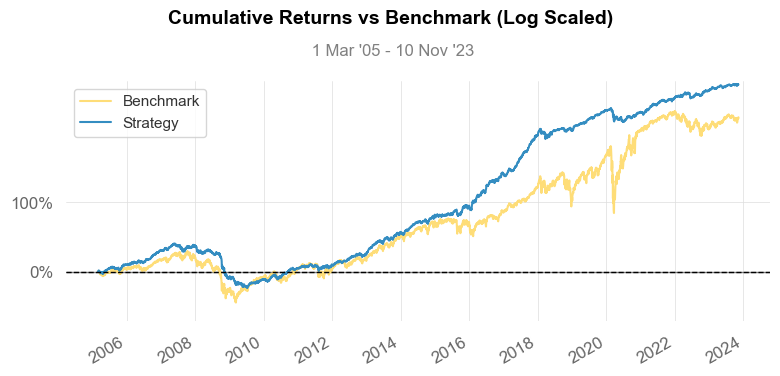

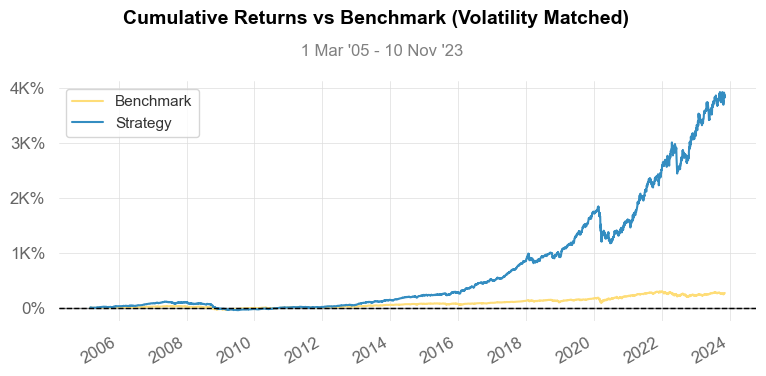

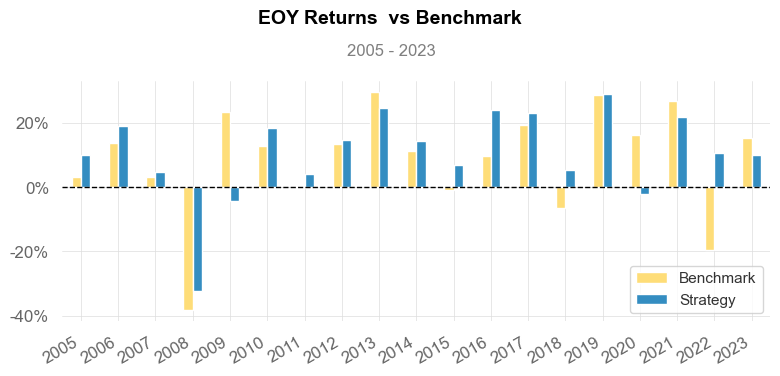

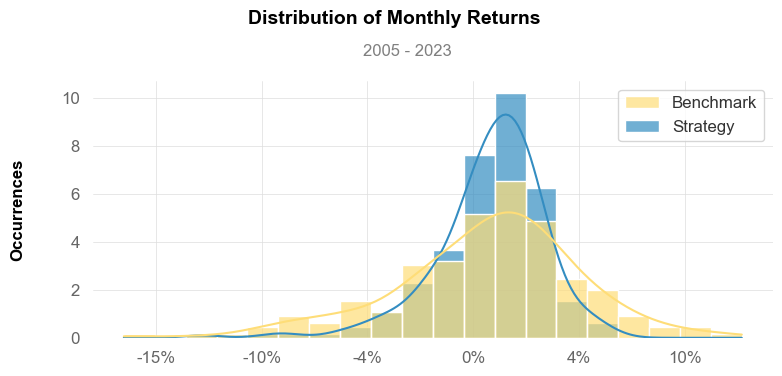

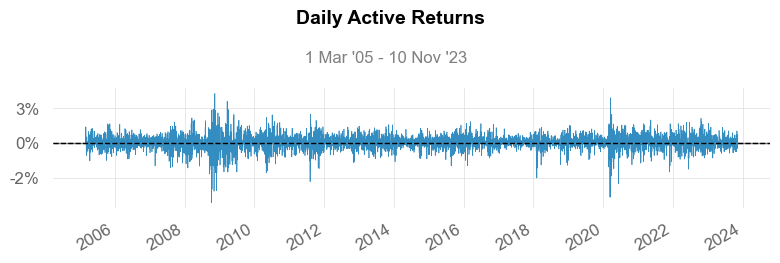

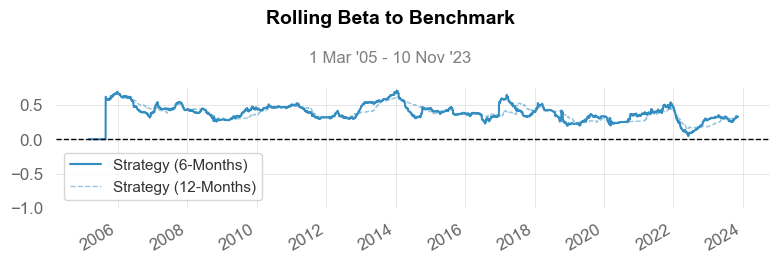

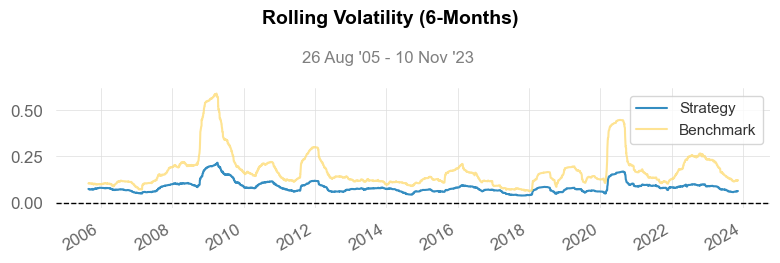

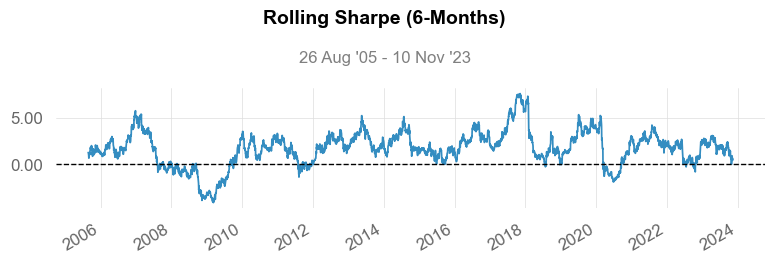

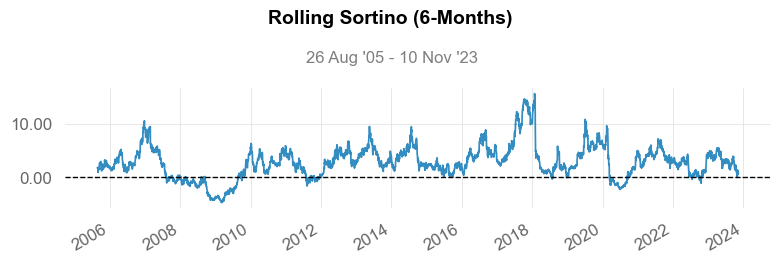

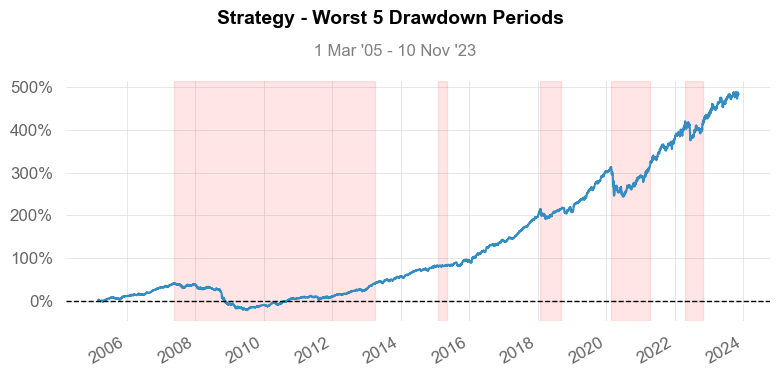

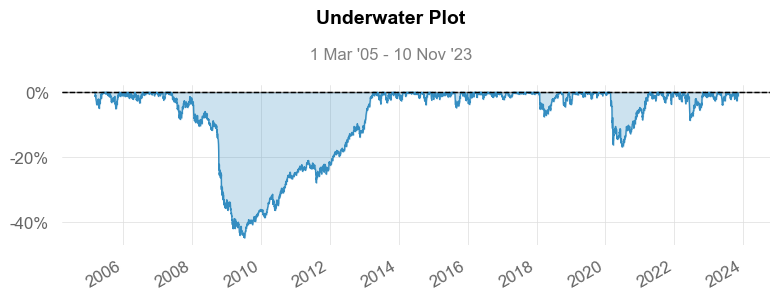

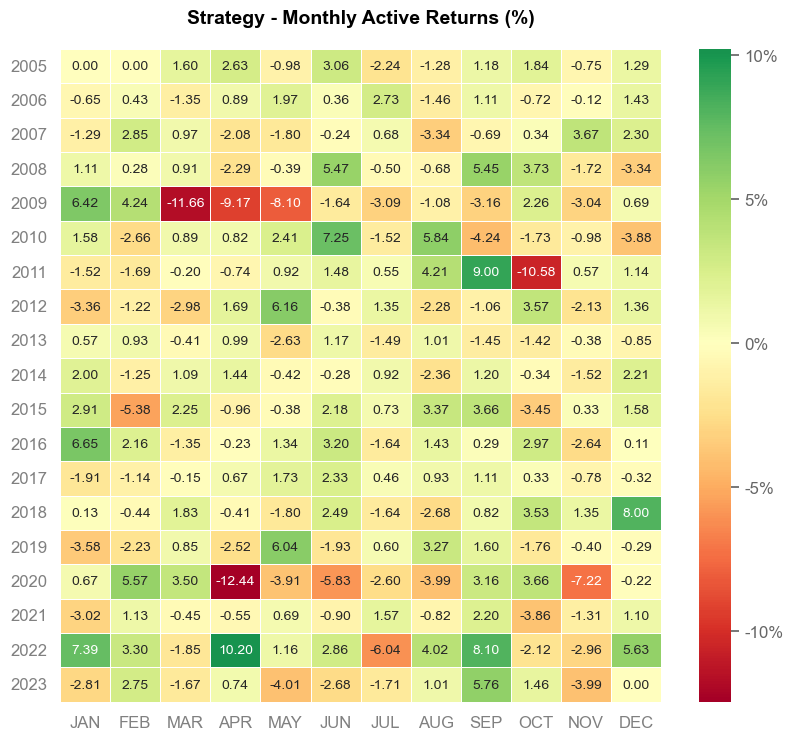

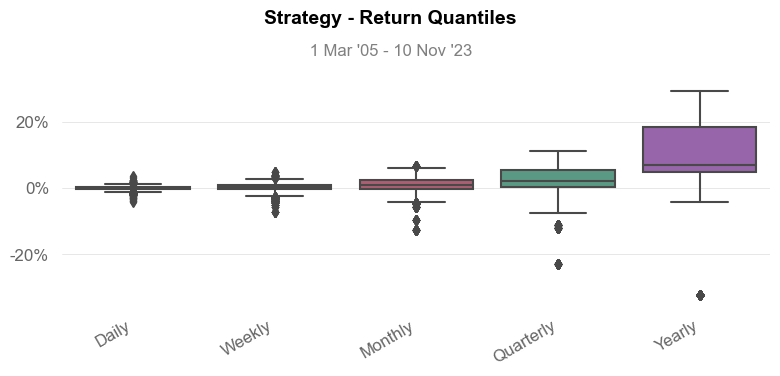

In [27]:
qs.reports.full(total_ret, 'SPY')

# Minimizing Market Exposure

In [83]:
def mfl(data, stocks_to_use, exp, min_exp_weights, lambda_):
    def objective_cvxpy(weights, betas, min_exp_weights, target_weights, lambda_):
        # Initialize the alternative objective
        alternative_objective = 0.0

        # Loop through each factor and calculate its contribution to the objective
        for factor, weight in min_exp_weights.items():
            port_beta = cp.matmul(weights, betas[factor])
            alternative_objective += weight * cp.abs(port_beta)
            # alternative_objective += weight * cp.square(port_beta)

        # Penalty for deviating from factor-based weights
        factor_penalty = cp.norm(weights - target_weights, 2)
        
        return alternative_objective + lambda_ * factor_penalty

    collect_weight = []
    count = 0 
    print(f'Processing {type}...')
    for date, row in stocks_to_use.iterrows():
        # Get betas for given stocks at day t
        betas = exp.loc[exp.index.get_level_values('date') == date]
        stocks = stocks_to_use.loc[stocks_to_use.index == date]['stock'][0]
        betas = get_stocks_data(betas, stocks)
        betas = betas.fillna(0)

        # Get target factor-based weights for the stocks
        current_target_weights = data.loc[(data.index.get_level_values('date') == date) & (data.index.get_level_values('permno').isin(stocks))]['final_weight']

        # CVXPY setup
        weights = cp.Variable(betas.shape[0])
        objective = cp.Minimize(objective_cvxpy(weights, betas, min_exp_weights, current_target_weights, lambda_))
        # Adjusted constraints for long-short strategy
        constraints = [
            cp.norm(weights, 1) <= 1, # 1-norm equals 1
            cp.sum(weights) == 0,     # Market neutrality
            weights <= 1, 
            weights >= -1
        ]
        prob = cp.Problem(objective, constraints)
        
        # Solve the problem
        prob.solve(solver='ECOS')
        collect_weight.append(weights.value)
        
        # Track performance
        if count % 30 == 0:
            print(date)
        count += 1
    
    return collect_weight

In [34]:
permno_per_date = []
date_unique = top_bottom_stocks.index.get_level_values('date').unique()
for date_group in date_unique:
    stocks = top_bottom_stocks.loc[top_bottom_stocks.index.get_level_values('date') == date_group].index.get_level_values('permno')
    permno_per_date.append(stocks.values.tolist())

In [35]:
stocks_to_use = pd.DataFrame(index=date_unique) 
stocks_to_use['stock'] = permno_per_date

In [81]:
# Read in calculate betas and convert from permno to ticker index
factor_col = f'SPY_RET_01_spy_01_{window}'
exp = beta_spy[[factor_col]]
min_exp_weights = {
     f'SPY_RET_01_spy_01_{window}' : 0.5
}
lambda_ = 0

In [73]:
test = set_timeframe(stocks_to_use, '2005-01-01', '2006-01-01')

In [84]:
# Calculate minimized-factor loading weights and sum it up to get strategy return
min_weights = mfl(top_bottom_stocks, test, exp, min_exp_weights, lambda_)

Processing <class 'type'>...
2005-01-31 00:00:00
2005-03-15 00:00:00
2005-04-27 00:00:00
2005-06-09 00:00:00
2005-07-22 00:00:00
2005-09-02 00:00:00
2005-10-17 00:00:00
2005-11-29 00:00:00


In [85]:
min_weights

[array([0.00000000e+000, 2.43207735e-310, 7.90505033e-323, 4.96026774e-312,
        4.96026772e-312, 4.96026773e-312, 4.96026773e-312, 4.95954644e-312,
        4.96026773e-312, 4.95954645e-312, 4.95954645e-312, 4.96026774e-312,
        4.95954643e-312, 4.96026774e-312, 4.96026773e-312, 4.95954644e-312,
        4.96026774e-312, 4.95954643e-312, 4.95954642e-312, 4.96026773e-312,
        4.96026774e-312, 4.95954644e-312, 4.96026773e-312, 4.95954644e-312,
        4.96026774e-312]),
 array([ 6.68061644e-314,  8.16519787e-314,  9.64977930e-314,
         1.11343607e-313,  1.26189422e-313,  1.41035236e-313,
         1.55881050e-313,  1.70726865e-313,  1.85572679e-313,
         2.00418493e-313,  2.15264308e-313,  2.30110122e-313,
         2.44955936e-313,  2.59801750e-313,  2.74647565e-313,
         2.89493379e-313,  3.04339193e-313,  3.19185008e-313,
         3.34030822e-313,  3.48876636e-313,  3.63722451e-313,
        -5.70079949e-311,  3.49807817e-001,  3.49807817e-001,
         3.49807817e-

In [53]:
top_bottom_stocks.shape

(235950, 21)

In [63]:
flattened_array = np.concatenate(min_weights).flatten()
flattened_weight = flattened_array.tolist()
len(flattened_weight)

235950

In [64]:
new_exposure = top_bottom_stocks.copy(deep=True)

In [66]:
new_exposure['exp_weight'] = flattened_weight
new_exposure['total_ret'] = new_exposure['RET_01'] * new_exposure['exp_weight']

In [69]:
total_ret = new_exposure.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-01   2005-02-01
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          272.89%      -99.19%
CAGR﹪                     4.96%        -16.23%

Sharpe                     0.46         -1.32
Prob. Sharpe Ratio         97.62%       0.0%
Smart Sharpe               0.42         -1.21
Sortino                    0.64         -1.63
Smart Sortino              0.59         -1.49
Sortino/√2                 0.45         -1.15
Smart Sortino/√2           0.42         -1.06
Omega                      0.78         0.78

Max Drawdown               -56.47%      -99.34%
Longest DD Days            1982         6767
Volatility (ann.)          19.44%       18.17%
R^2                        0.08         0.08
Information Ratio          -0.07        -0.07
Calmar     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2005-05-02,2021-06-09,2023-11-10,6767,-99.339980,-99.309266
2,2005-04-15,2005-04-20,2005-04-22,8,-2.009542,-1.708824
3,2005-03-11,2005-03-24,2005-03-29,19,-1.974523,-1.627273
4,2005-03-02,2005-03-02,2005-03-02,1,-0.675530,NaN
5,2005-04-07,2005-04-07,2005-04-08,2,-0.231444,-0.100676


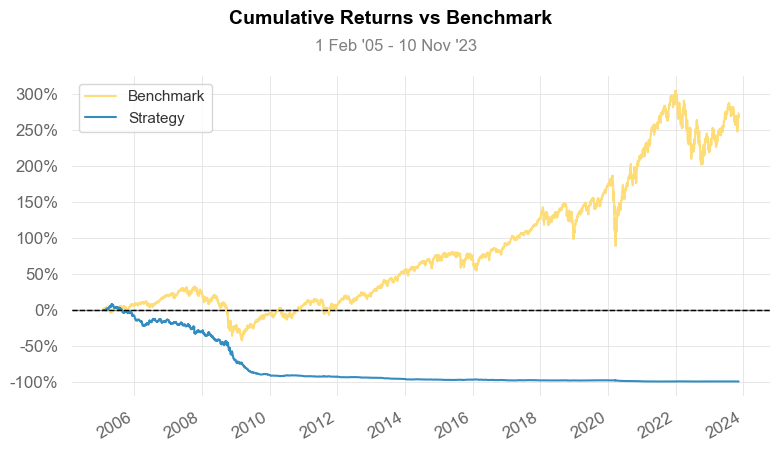

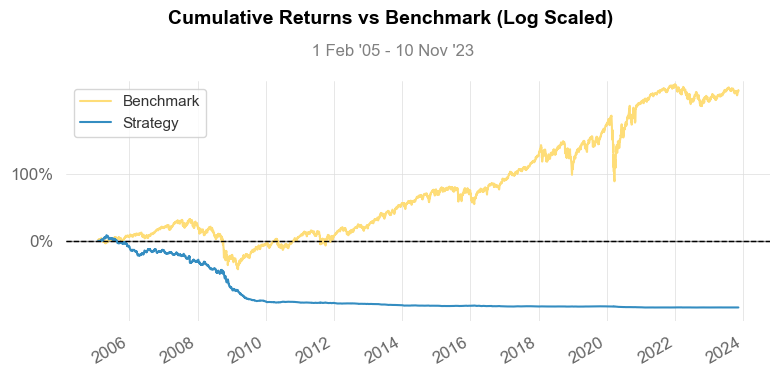

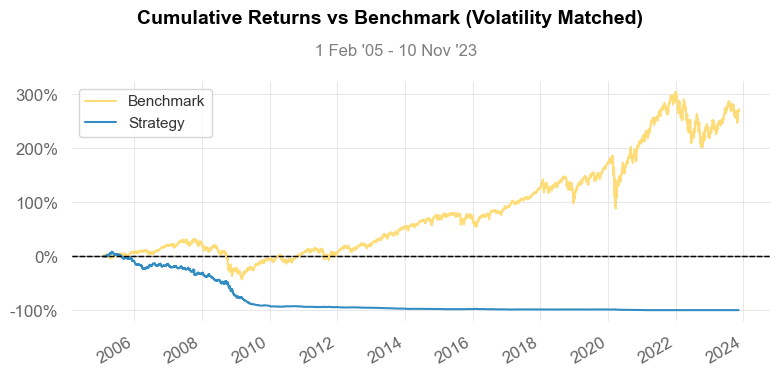

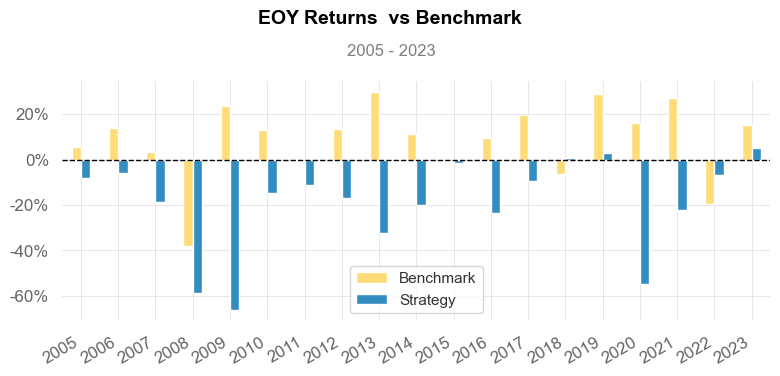

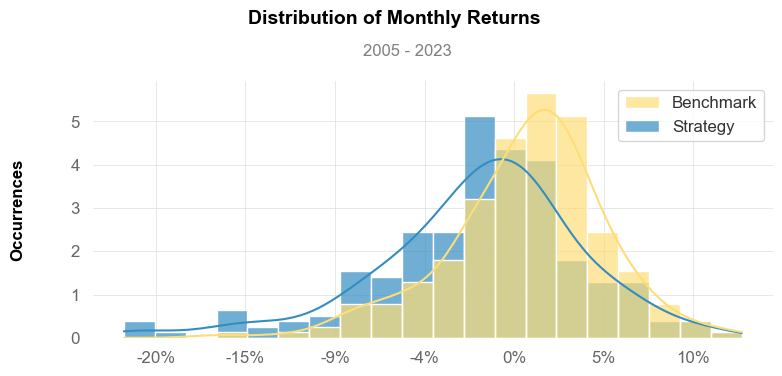

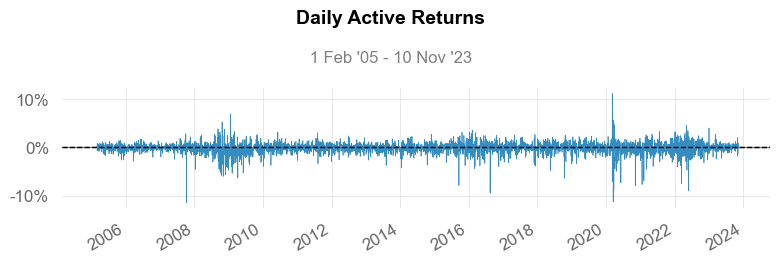

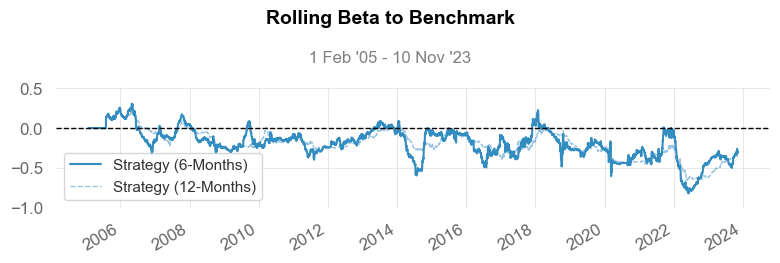

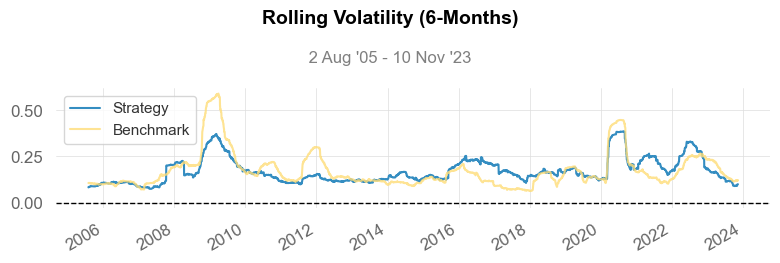

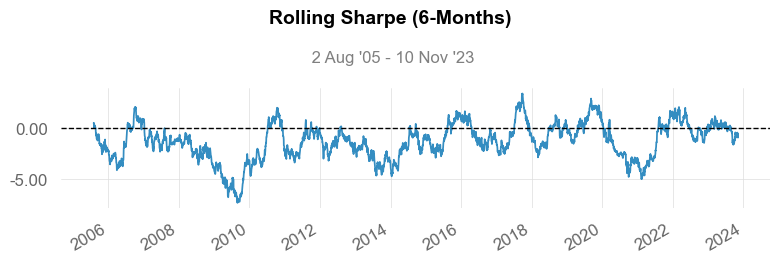

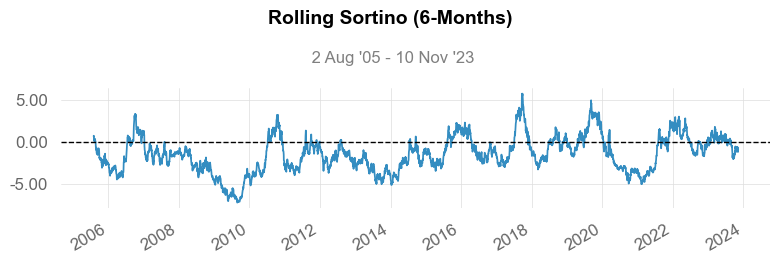

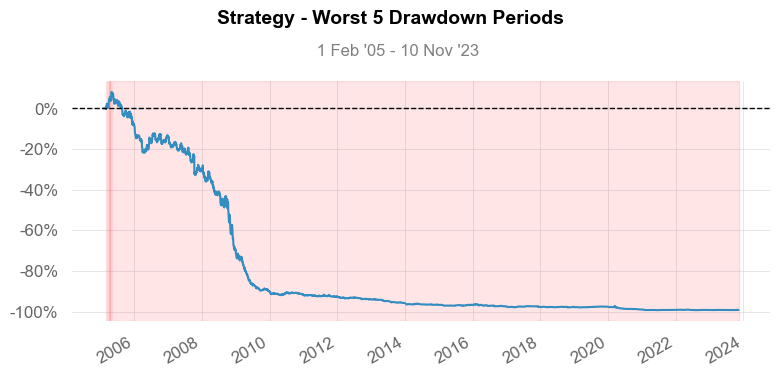

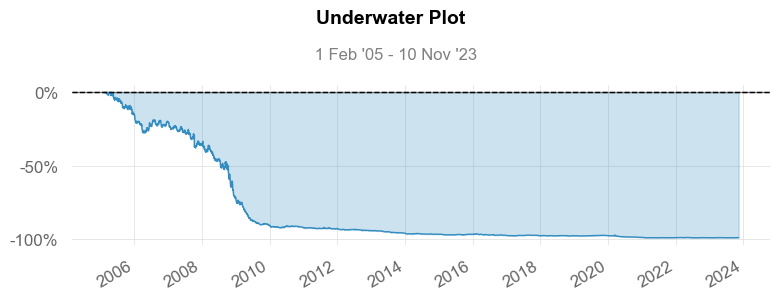

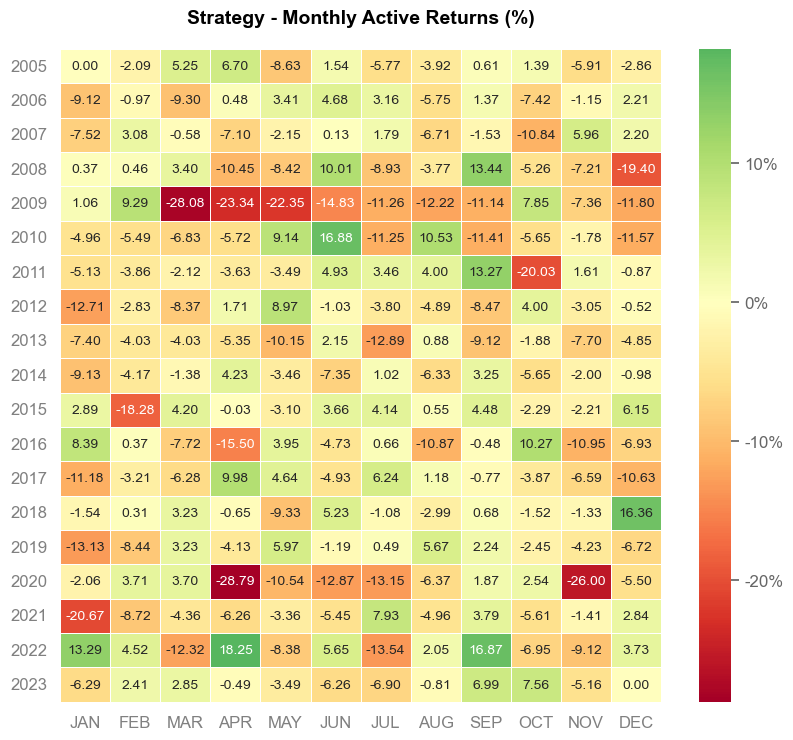

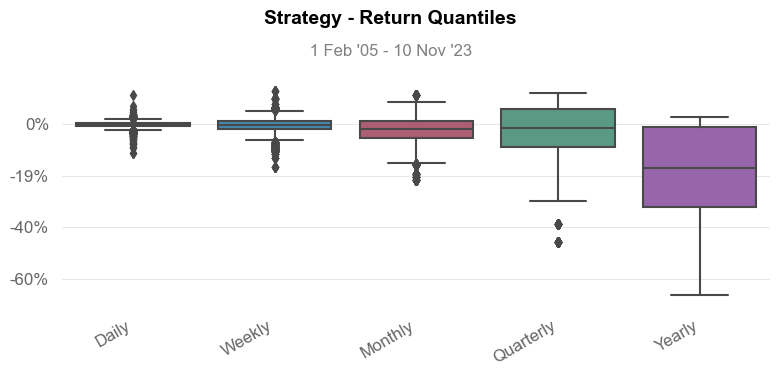

In [70]:
qs.reports.full(total_ret, 'SPY')